# Geographic Feature Creation

Created by: Orsi Vasarhelyi

Contact: orsolya.vasarhelyi@gmail.com

Last updated: 10.07.2018.

Data source: http://www.mapcruzin.com/free-italy-arcgis-maps-shapefiles.htm

Creates voranoi based statistics of each location


In [120]:

#analysis
import pandas as pd
import numpy as np 
from collections import Counter, defaultdict
import geopandas as gpd

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

import numpy as np

import sys
sys.path.append("..")
from connect_db import db_connection

In [121]:
# load data from TPT 
regions = r"/mnt/data/shared/Boundaries regions and municipalities Italy 2016/Reg2016_WGS84_g/Reg_2016_WGS84_g.shp"
provinces = r"/mnt/data/shared/Boundaries regions and municipalities Italy 2016/CMProv2016_WGS84_g/CMprov2016_WGS84_g.shp"
municipalities = r"/mnt/data/shared/Boundaries regions and municipalities Italy 2016/Com2016_WGS84_g/Com2016_WGS84_g.shp"
new_reg =  r"/mnt/data/shared/ITA_shapefiles/Tus_28districts.shp"

# important cities 
important_cities_file = r"/mnt/data/shared/important_cities.csv"

df_reg = gpd.read_file(regions)
df_pro = gpd.read_file(provinces)
df_mun = gpd.read_file(municipalities)
df_newreg = gpd.read_file(new_reg)
important_cities = pd.read_csv(important_cities_file)


df_reg['geometry'] = df_reg['geometry'].to_crs(epsg=4326)
df_pro['geometry'] = df_pro['geometry'].to_crs(epsg=4326)
df_mun['geometry'] = df_mun['geometry'].to_crs(epsg=4326)

df_reg_tusc = df_reg[df_reg["COD_REG"] == 9] # tuscany
df_pro_tusc = df_pro[df_pro["COD_REG"] == 9]
df_mun_tusc = df_mun[df_mun["COD_REG"] == 9]


In [122]:
df_mun[df_mun['COMUNE']=='Arezzo']

,COD_REG,COD_CM,COD_PRO,PRO_COM,COMUNE,NOME_TED,FLAG_CM,SHAPE_Leng,SHAPE_Area,geometry
2209,9,0,51,51002,Arezzo,None,2,112025.299215,3.837878e+08,"POLYGON ((11.86421691033788 43.55692961358602,..."


In [4]:
crs= {'init' :'epsg:4326'}

In [5]:
df_mun_tusc.crs = crs

# Natural Parks and Resources

In [45]:
n=gpd.read_file('/mnt/data/shared/ITA_location_features/italy-natural-shape/natural.shp')

In [46]:
n['geometry'] = n['geometry'].to_crs(epsg=4326)

In [48]:
n.crs = crs

In [49]:
places_in_tusc_list=list(gpd.sjoin(n, df_mun_tusc, op='intersects')['osm_id'])

In [50]:
def places_in_tusc(row):
    if row['osm_id'] in places_in_tusc_list:
        return 1
    else:
        return 0

In [51]:
n['tusc']=n.apply(places_in_tusc,1)

In [52]:
n2=n[n['tusc']==1]

In [53]:
n2['type'].value_counts()

water        199
forest       113
park          99
riverbank     26
Name: type, dtype: int64

In [54]:
def add_colors_nat(row):
    if row['type']=='forest':
        return "green"
    elif row['type']=='park':
        return "brown"
    elif row['type']=='riverbank':
        return "pink"
    elif row['type']=='water':
        return "blue"

In [55]:
n2['colors']=n2.apply(add_colors_nat,1)

/home/ovasarhelyi/.conda/envs/velf/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [95]:
n['area']=n.area

In [97]:
n.groupby('type')['area'].sum()

type
forest       0.733053
park         0.014416
riverbank    0.029512
water        0.229336
Name: area, dtype: float64

### Voranoids and locations


In [58]:
#vors_data=gpd.read_file('/mnt/data/shared/tuscany_municipalities_with_voronois_ids.shp')

In [93]:
vor_s=gpd.read_file('/mnt/data/shared/locations_with_voronois_shapes.shp')

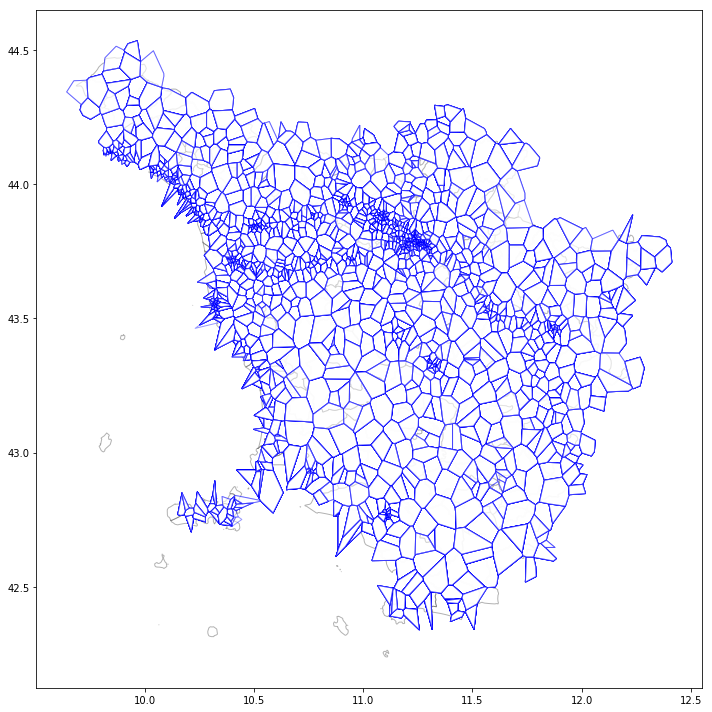

In [431]:
fig, ax = plt.subplots(figsize=(10, 10))

df_mun_tusc.plot(ax=ax, edgecolor='black', color='white', alpha=0.3, figsize=(10, 10))
ax=vor_s.plot(ax=ax, edgecolor='blue', color='white', figsize=(10, 10), alpha=0.4)
plt.tight_layout()

In [203]:
vor_s.head()

,location_i,lat,lon,region,geometry
index_left,,,,,
0,3636164.0,43.925,10.2984,9.0,"POLYGON ((10.32461874541338 43.93060042548208,..."
1,3636161.0,43.925,10.2984,9.0,"POLYGON ((10.32461874541338 43.93060042548208,..."
2,57521031.0,43.925,10.2984,9.0,"POLYGON ((10.32461874541338 43.93060042548208,..."
3,3612587.0,43.925,10.2984,9.0,"POLYGON ((10.32461874541338 43.93060042548208,..."
4,3062831.0,43.925,10.2984,9.0,"POLYGON ((10.32461874541338 43.93060042548208,..."


In [205]:
len(locations_with_parks)

25427

In [263]:
G = n2["geometry"].apply(lambda geom: geom.wkb)
n2 = n2.loc[G.drop_duplicates().index]

In [264]:
a=gpd.overlay(vor_s, n2, how='intersection')

In [278]:
for i in a['type'].value_counts().index:
    a[i+'_area']=a[a['type']==i].area.astype(float)

In [281]:
b=a[['location_i',"forest_area","water_area","park_area","riverbank_area"]].groupby('location_i').sum()

In [296]:
b.head()

,forest_area,water_area,park_area,riverbank_area
location_i,,,,
3007371.0,0.000000,0.00000,1.080407e-06,0.00000
3007461.0,0.000013,0.00000,0.000000e+00,0.00000
3007561.0,0.000000,0.00003,0.000000e+00,0.00000
3007872.0,0.000000,0.00000,3.566044e-07,0.00000
3008153.0,0.000334,0.00000,0.000000e+00,0.00002


In [286]:
cs=a[a['type'].notnull()]["colors"]

In [295]:
vor_s_with_parks=vor_s.set_index('location_i').join(b)

/home/ovasarhelyi/.conda/envs/velf/lib/python3.6/site-packages/geopandas/plotting.py:389: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "'color'.", UserWarning)


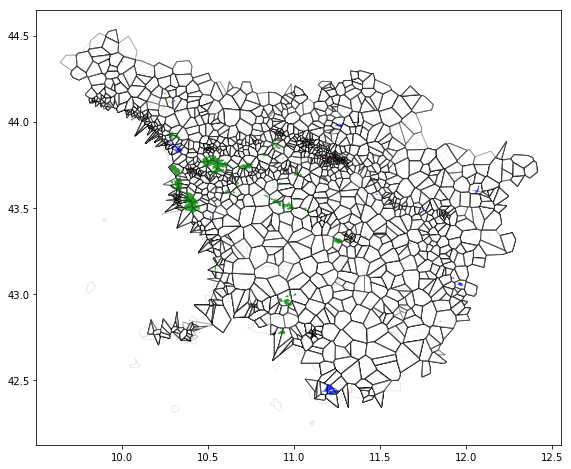

In [436]:
ax=df_mun_tusc.plot(figsize=(30, 30), edgecolor='lightgrey', color='white', alpha=0.5)
#ax=vor_s.plot(ax=ax, edgecolor='blue', color='white', figsize=(20, 15), alpha=0.2)
ax=vor_s.plot(ax=ax, edgecolor='black', color='white', alpha=0.2)
a[a['type'].notnull()].plot(ax=ax,column='type', color=list(cs) , alpha=0.8)


# Points of interest

In [297]:
p=gpd.read_file('/mnt/data/shared/ITA_location_features/italy-points-shape/points.shp')

In [298]:
p.head()

,osm_id,name,type,geometry
0,172072,Novara,motorway_junctio,POINT (8.673941599999999 45.46838)
1,879368,None,traffic_signals,POINT (11.0984808 43.892765)
2,918437,None,traffic_signals,POINT (11.2819149 43.7658372)
3,1313296,None,level_crossing,POINT (10.4941752 43.4003768)
4,1433338,None,traffic_signals,POINT (11.1148742 43.8760112)


In [299]:
len(p[p['type']=='attraction'])

299

# Parsed Points of Interests

In [301]:
p2=pd.read_csv("/mnt/data/shared/points_of_interest.csv")

In [302]:
p2=p2.dropna(subset=['lng', 'lat'])

In [303]:
from shapely.geometry import Point

p2['geometry'] = p2.apply(lambda x: Point((float(x.lng), float(x.lat))), axis=1)
D=gpd.GeoDataFrame(p2)
D.crs =  crs

In [326]:
d=D[D['type']=='attrazioni']

In [327]:
#d=D[(D['type']=='attrazioni')| (D['type']=='localita')]

In [328]:
d[['type', 'geometry']].head()

,type,geometry
0,attrazioni,POINT (11.218748 43.833555)
1,attrazioni,POINT (10.68319589999999 43.43064649999999)
2,attrazioni,POINT (10.095396 44.080474)
3,attrazioni,POINT (9.818073199999956 43.0377826)
4,attrazioni,POINT (11.206276 43.84069)


In [330]:
#D['type'].value_counts()

In [331]:
j=gpd.sjoin(vor_s_with_parks, d[['type', 'geometry']], op='contains')

In [337]:
len(vor_s_with_parks)

19649

In [334]:
j=j.replace('attrazioni', 1)

In [338]:
j['location_id']=j.index

In [339]:
k=j[['location_id','type']].groupby('location_id').sum()

In [404]:
vor_s_with_parks_attractions=vor_s_with_parks.join(k.rename(columns={'type':'num_attractions'}))

In [405]:
vor_s_with_parks_attractions.sort_values('num_attractions', ascending=False).head()

,lat,lon,region,geometry,forest_area,water_area,park_area,riverbank_area,num_attractions
index_left,,,,,,,,,
3042341.0,43.3148,11.3281,9.0,"POLYGON ((11.33023245921768 43.29912565339414,...",NaN,NaN,NaN,NaN,15.0
3654601.0,43.3148,11.3281,9.0,"POLYGON ((11.33023245921768 43.29912565339414,...",NaN,NaN,NaN,NaN,15.0
3654605.0,43.3148,11.3281,9.0,"POLYGON ((11.33023245921768 43.29912565339414,...",NaN,NaN,NaN,NaN,15.0
3654604.0,43.3148,11.3281,9.0,"POLYGON ((11.33023245921768 43.29912565339414,...",NaN,NaN,NaN,NaN,15.0
3654603.0,43.3148,11.3281,9.0,"POLYGON ((11.33023245921768 43.29912565339414,...",NaN,NaN,NaN,NaN,15.0


# Places

In [2]:
places=gpd.read_file("/mnt/data/shared/ITA_location_features/italy-places-shape/places.shp")

In [3]:
places.head()

,osm_id,name,type,population,geometry
0,15419779,Sibari Marina,village,0,POINT (16.483597 39.7463713)
1,26347360,Italia,country,0,POINT (12.6 42.4)
2,26608813,Catania-Fontanarossa Airport,airport,0,POINT (15.0663446 37.46742)
3,26608814,Aeroporto di Milano-Malpensa,airport,0,POINT (8.726209300000001 45.6297186)
4,26608815,Turin International Airport,airport,0,POINT (7.6486544 45.2005116)


In [388]:
locs=['village', 'town', 'locality', 'suburb', 'city', 'island', 'airport']

In [427]:
vor_s_with_parks_attractions_locs=vor_s_with_parks_attractions
for loc in locs:
    m=gpd.sjoin(vor_s_with_parks_attractions, places[places['type']==loc],  op='contains')
    m=m.replace(loc,1)
    m['location_id']=m.index
    m['num_'+loc]=m.groupby('location_id')['type'].sum()
    if loc == 'island' or loc == 'airport':
        vor_s_with_parks_attractions_locs=vor_s_with_parks_attractions_locs.join(m[['num_'+loc]])
    else:
        m['pop_'+loc]=m.groupby('location_id')['population'].mean()
        m['pop_max_'+loc]=m.groupby('location_id')['population'].max()
        vor_s_with_parks_attractions_locs=vor_s_with_parks_attractions_locs.join(m[['num_'+loc, 'pop_'+loc, 'pop_max_'+loc]])
    

In [429]:
vor_s_with_parks_attractions_locs.sort_values('pop_city', ascending=False)

,lat,lon,region,geometry,forest_area,water_area,park_area,riverbank_area,num_attractions,num_village,...,pop_locality,pop_max_locality,num_suburb,pop_suburb,pop_max_suburb,num_city,pop_city,pop_max_city,num_island,num_airport
59924053.0,43.7715,11.2543,9.0,"POLYGON ((11.25726519788918 43.77130372031663,...",0.000000,0.0,0.000000e+00,9.862640e-08,8.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,356118.0,356118.0,NaN,NaN
59924052.0,43.7715,11.2543,9.0,"POLYGON ((11.25726519788918 43.77130372031663,...",NaN,NaN,NaN,NaN,8.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,356118.0,356118.0,NaN,NaN
59924031.0,43.7715,11.2543,9.0,"POLYGON ((11.25726519788918 43.77130372031663,...",NaN,NaN,NaN,NaN,8.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,356118.0,356118.0,NaN,NaN
59924032.0,43.7715,11.2543,9.0,"POLYGON ((11.25726519788918 43.77130372031663,...",NaN,NaN,NaN,NaN,8.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,356118.0,356118.0,NaN,NaN
59924033.0,43.7715,11.2543,9.0,"POLYGON ((11.25726519788918 43.77130372031663,...",NaN,NaN,NaN,NaN,8.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,356118.0,356118.0,NaN,NaN
3653931.0,43.8822,11.0975,9.0,"POLYGON ((11.10154832869081 43.88204554317549,...",NaN,NaN,NaN,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,172499.0,172499.0,NaN,NaN
3061643.0,43.8822,11.0975,9.0,"POLYGON ((11.10154832869081 43.88204554317549,...",NaN,NaN,NaN,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,172499.0,172499.0,NaN,NaN
3061642.0,43.8822,11.0975,9.0,"POLYGON ((11.10154832869081 43.88204554317549,...",NaN,NaN,NaN,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,172499.0,172499.0,NaN,NaN
3061641.0,43.8822,11.0975,9.0,"POLYGON ((11.10154832869081 43.88204554317549,...",NaN,NaN,NaN,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,172499.0,172499.0,NaN,NaN
59028033.0,43.8822,11.0975,9.0,"POLYGON ((11.10154832869081 43.88204554317549,...",NaN,NaN,NaN,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,172499.0,172499.0,NaN,NaN


# Important cities



In [432]:
important_cities_file = r"/mnt/data/shared/important_cities.csv"

In [441]:
important_cities = pd.read_csv(important_cities_file)

In [444]:
important_cities['coordinates']  = list(zip(important_cities.long, important_cities.lat))
important_cities['geometry'] = important_cities['coordinates'].apply(Point)
del important_cities['coordinates']

In [447]:
important_cities.crs=crs

/home/ovasarhelyi/.conda/envs/velf/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [450]:
c=gpd.sjoin(vor_s_with_parks_attractions_locs, important_cities,  op='contains', how='left')

In [452]:
c.city.value_counts()

Pistoia     24
Carrara     24
Pisa        23
Lucca       21
Livorno     18
Siena       12
Florence     5
Grosetto     5
Arezzo       3
Name: city, dtype: int64

In [457]:
vor_s_with_parks_attractions_locs_citdies=vor_s_with_parks_attractions_locs.join(pd.get_dummies(c.city).drop_duplicates())

In [472]:
vor_s_with_parks_attractions_locs_cities.head()

,lat,lon,region,geometry,forest_area,water_area,park_area,riverbank_area,num_attractions,num_village,...,num_airport,Arezzo,Carrara,Florence,Grosetto,Livorno,Lucca,Pisa,Pistoia,Siena
1106531.0,44.1859,9.8663,9.0,"POLYGON ((9.902204800481108 44.19835701146172,...",NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1106531.0,44.1859,9.8663,9.0,"POLYGON ((9.902204800481108 44.19835701146172,...",NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1106532.0,44.1859,9.8663,9.0,"POLYGON ((9.902204800481108 44.19835701146172,...",NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1106532.0,44.1859,9.8663,9.0,"POLYGON ((9.902204800481108 44.19835701146172,...",NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1106533.0,44.1859,9.8663,9.0,"POLYGON ((9.902204800481108 44.19835701146172,...",NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Get the Coast

In [459]:
df_mun.crs=crs

In [461]:
df_it=df_mun.unary_union.boundary

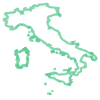

In [463]:
df_it

In [465]:
tusc=df_mun_tusc.unary_union.boundary

In [467]:
coast=tusc.intersection(df_it)

In [474]:
#h=vor_s_with_parks_attractions_locs_cities.within(coast)

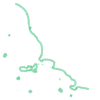

In [475]:
coast

In [479]:
coast_points=vor_s_with_parks_attractions_locs_cities.intersection(coast)

In [ ]:
coast_points

In [482]:
coast_points2=coast_points.drop_duplicates()

In [510]:
type(coast_points2[3005791.0])

shapely.geometry.multilinestring.MultiLineString

In [489]:
vor_s_with_parks_attractions_locs_cities_coast=vor_s_with_parks_attractions_locs_cities.join(pd.DataFrame(coast_points2))

In [494]:
#vor_s_with_parks_attractions_locs_cities_coast=vor_s_with_parks_attractions_locs_cities_coast.drop_duplicates()

In [496]:
vor_s_with_parks_attractions_locs_cities_coast2=vor_s_with_parks_attractions_locs_cities_coast

In [497]:
del vor_s_with_parks_attractions_locs_cities_coast['geometry']

In [521]:
vor_s_with_parks_attractions_locs_cities_coast.head()

,lat,lon,region,forest_area,water_area,park_area,riverbank_area,num_attractions,num_village,pop_village,...,Arezzo,Carrara,Florence,Grosetto,Livorno,Lucca,Pisa,Pistoia,Siena,coast
1106531.0,44.1859,9.8663,9.0,NaN,NaN,NaN,NaN,NaN,2.0,4024.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1106531.0,44.1859,9.8663,9.0,NaN,NaN,NaN,NaN,NaN,2.0,4024.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1106531.0,44.1859,9.8663,9.0,NaN,NaN,NaN,NaN,NaN,2.0,4024.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1106531.0,44.1859,9.8663,9.0,NaN,NaN,NaN,NaN,NaN,2.0,4024.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1106532.0,44.1859,9.8663,9.0,NaN,NaN,NaN,NaN,NaN,2.0,4024.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [514]:
import shapely

In [515]:
def get_coast(row):
    if type(row[0])==shapely.geometry.multilinestring.MultiLineString:
        return 1
    else:
        return 0

In [516]:
vor_s_with_parks_attractions_locs_cities_coast2['coast']=vor_s_with_parks_attractions_locs_cities_coast2.apply(get_coast,1)

In [ ]:
del vor_s_with_parks_attractions_locs_cities_coast[0]

In [533]:
vor_s_with_parks_attractions_locs_cities_coast['location_id']=vor_s_with_parks_attractions_locs_cities_coast.index

In [534]:
len(vor_s_with_parks_attractions_locs_cities_coast)

21360

In [535]:
vor_s_with_parks_attractions_locs_cities_coast3=vor_s_with_parks_attractions_locs_cities_coast.drop_duplicates()

In [536]:
vor_s_with_parks_attractions_locs_cities_coast3=vor_s_with_parks_attractions_locs_cities_coast3.replace(np.nan,0)

In [537]:
vor_s_with_parks_attractions_locs_cities_coast3.describe()

,lat,lon,region,forest_area,water_area,park_area,riverbank_area,num_attractions,num_village,pop_village,...,Carrara,Florence,Grosetto,Livorno,Lucca,Pisa,Pistoia,Siena,coast,location_id
count,19649.000000,19649.000000,19649.000000,19649.000000,1.964900e+04,1.964900e+04,1.964900e+04,19649.000000,19649.000000,19649.000000,...,19649.000000,19649.000000,19649.000000,19649.000000,19649.000000,19649.000000,19649.000000,19649.000000,19649.000000,1.964900e+04
mean,43.601690,10.948129,8.956486,0.000002,3.103116e-07,1.807492e-08,2.027451e-08,0.460685,0.284951,500.473697,...,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.004886,1.658933e+07
std,0.412402,0.539967,0.411052,0.000040,1.394931e-05,5.306848e-07,5.016218e-07,1.178619,0.602298,1577.895657,...,0.007134,0.007134,0.007134,0.007134,0.007134,0.007134,0.007134,0.007134,0.069729,2.353691e+07
min,42.390100,9.695200,7.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.106531e+06
25%,43.399100,10.497800,9.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.600364e+06
50%,43.724000,11.024400,9.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.630245e+06
75%,43.877200,11.283700,9.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.661603e+06
max,44.505200,12.376600,12.000000,0.002258,1.614827e-03,3.937064e-05,2.604851e-05,15.000000,6.000000,9914.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.965003e+07


In [538]:
len(vor_s)

19649

In [541]:
len(vor_s_with_parks_attractions_locs_cities_coast3)

19649

In [551]:
final_location_matrix=vor_s[['geometry', 'location_i']].set_index('location_i').join(vor_s_with_parks_attractions_locs_cities_coast3.set_index('location_id'))

In [557]:
final_location_matrix.columns

Index(['geometry', 'lat', 'lon', 'region', 'forest_area', 'water_area',
       'park_area', 'riverbank_area', 'num_attractions', 'num_village',
       'pop_village', 'pop_max_village', 'num_town', 'pop_town',
       'pop_max_town', 'num_locality', 'pop_locality', 'pop_max_locality',
       'num_suburb', 'pop_suburb', 'pop_max_suburb', 'num_city', 'pop_city',
       'pop_max_city', 'num_island', 'num_airport', 'Arezzo', 'Carrara',
       'Florence', 'Grosetto', 'Livorno', 'Lucca', 'Pisa', 'Pistoia', 'Siena',
       'coast'],
      dtype='object')

In [559]:
final_location_matrix.describe()

,lat,lon,region,forest_area,water_area,park_area,riverbank_area,num_attractions,num_village,pop_village,...,Arezzo,Carrara,Florence,Grosetto,Livorno,Lucca,Pisa,Pistoia,Siena,coast
count,19649.000000,19649.000000,19649.000000,19649.000000,1.964900e+04,1.964900e+04,1.964900e+04,19649.000000,19649.000000,19649.000000,...,19649.000000,19649.000000,19649.000000,19649.000000,19649.000000,19649.000000,19649.000000,19649.000000,19649.000000,19649.000000
mean,43.601690,10.948129,8.956486,0.000002,3.103116e-07,1.807492e-08,2.027451e-08,0.460685,0.284951,500.473697,...,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.000051,0.004886
std,0.412402,0.539967,0.411052,0.000040,1.394931e-05,5.306848e-07,5.016218e-07,1.178619,0.602298,1577.895657,...,0.007134,0.007134,0.007134,0.007134,0.007134,0.007134,0.007134,0.007134,0.007134,0.069729
min,42.390100,9.695200,7.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,43.399100,10.497800,9.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,43.724000,11.024400,9.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,43.877200,11.283700,9.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,44.505200,12.376600,12.000000,0.002258,1.614827e-03,3.937064e-05,2.604851e-05,15.000000,6.000000,9914.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [556]:
final_location_matrix.to_csv('/mnt/data/shared/location_id_with_features.csv')

# Changing city data to polygons to get better results

In [83]:
# Change polygons of cities

In [84]:
df_mun[df_mun['COMUNE']=='Arezzo']

,COD_REG,COD_CM,COD_PRO,PRO_COM,COMUNE,NOME_TED,FLAG_CM,SHAPE_Leng,SHAPE_Area,geometry
2209,9,0,51,51002,Arezzo,None,2,112025.299215,3.837878e+08,"POLYGON ((11.86421691033788 43.55692961358602,..."


In [85]:
df_mun.crs=crs

In [86]:
df=pd.read_csv('/mnt/data/shared/location_id_with_features2.csv')

In [87]:
df.head()

,Unnamed: 0,location_i,lat,lon,region,forest_area,water_area,park_area,riverbank_area,num_attractions,...,Arezzo,Carrara,Florence,Grosetto,Livorno,Lucca,Pisa,Pistoia,Siena,coast
0,0,3636164.0,43.925,10.2984,9.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1,3636161.0,43.925,10.2984,9.0,0.000346,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2,57521031.0,43.925,10.2984,9.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,3,3612587.0,43.925,10.2984,9.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,4,3062831.0,43.925,10.2984,9.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [88]:
from shapely.geometry import Point

In [89]:
df['geometry']= [Point(xy) for xy in zip(df.lon, df.lat)]

In [90]:
gdf = gpd.GeoDataFrame(df, crs=crs, geometry=df.geometry)

In [91]:
gdf=gdf.set_index('location_i')

In [92]:
m=gpd.sjoin(df_mun[df_mun['COMUNE']=='Arezzo'], gdf,  op='contains')

In [93]:
for i in cities:
    del gdf[i]

In [94]:
26.07.26.07.del gdf['Unnamed: 0']

In [108]:
cities=['Arezzo', 'Carrara', 'Firenze', 'Grosseto', 'Livorno', 'Lucca', 'Pisa',
       'Pistoia', 'Siena']

In [109]:
gdf2=gdf
for city in cities:
    if city in df_mun['COMUNE'].value_counts().index:
        c=df_mun[df_mun['COMUNE']==city]
        m=gpd.sjoin(gdf, c,  op='intersects')
        m=m.replace(city,1)
        m['location_id']=m.index
        m[city]=m.groupby('location_id')['COMUNE'].sum()
        gdf2=gdf2.join(m[[city].lower()])

Exception ignored in: <bound method Handle.__del__ of <rtree.index.IndexStreamHandle object at 0x7ff643d64320>>
Traceback (most recent call last):
  File "/home/ovasarhelyi/.conda/envs/velf/lib/python3.6/site-packages/rtree/index.py", line 875, in __del__
    self.destroy()
  File "/home/ovasarhelyi/.conda/envs/velf/lib/python3.6/site-packages/rtree/index.py", line 863, in destroy
    if self._ptr is not None:
AttributeError: 'IndexStreamHandle' object has no attribute '_ptr'


In [111]:
gdf2.columns

Index(['lat', 'lon', 'region', 'forest_area', 'water_area', 'park_area',
       'riverbank_area', 'num_attractions', 'num_village', 'pop_village',
       'pop_max_village', 'num_town', 'pop_town', 'pop_max_town',
       'num_locality', 'pop_locality', 'pop_max_locality', 'num_suburb',
       'pop_suburb', 'pop_max_suburb', 'num_city', 'pop_city', 'pop_max_city',
       'num_island', 'num_airport', 'coast', 'geometry', 'Arezzo', 'Carrara',
       'Firenze', 'Livorno', 'Lucca', 'Pisa', 'Pistoia', 'Siena'],
      dtype='object')

In [112]:
gdf2['location_id']=gdf2.index

In [115]:
del gdf2['geometry']

In [116]:
gdf2.head()

,lat,lon,region,forest_area,water_area,park_area,riverbank_area,num_attractions,num_village,pop_village,...,coast,Arezzo,Carrara,Firenze,Livorno,Lucca,Pisa,Pistoia,Siena,location_id
index_left,,,,,,,,,,,,,,,,,,,,,
3636164.0,43.925,10.2984,9.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3636164.0
3636161.0,43.925,10.2984,9.0,0.000346,0.0,0.0,0.0,0.0,1.0,0.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3636161.0
57521031.0,43.925,10.2984,9.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57521031.0
3612587.0,43.925,10.2984,9.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3612587.0
3062831.0,43.925,10.2984,9.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3062831.0


In [117]:
gdf2.to_csv('/mnt/data/shared/loca_id_features2.csv', index=False)

In [118]:
pd.read_csv('/mnt/data/shared/loca_id_features2.csv').head()

,lat,lon,region,forest_area,water_area,park_area,riverbank_area,num_attractions,num_village,pop_village,...,coast,Arezzo,Carrara,Firenze,Livorno,Lucca,Pisa,Pistoia,Siena,location_id
0,43.925,10.2984,9.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3636164.0
1,43.925,10.2984,9.0,0.000346,0.0,0.0,0.0,0.0,1.0,0.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3636161.0
2,43.925,10.2984,9.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57521031.0
3,43.925,10.2984,9.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3612587.0
4,43.925,10.2984,9.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3062831.0
